In marketing, the CLV is one of the key metrics to have and monitor. The CLV measures
customers' total worth to the business over the course of their lifetime relationship with the
company. This metric is especially important to keep track of for acquiring new customers.
It is generally more expensive to acquire new customers than to keep existing customers, so
knowing the lifetime value and the costs associated with acquiring new customers is
essential in order to build marketing strategies with a positive ROI. For example, if the
average CLV of your customer is $100 and it only costs $10 to acquire a new customer, then
your business will be generating more revenue as you acquire new customers.

# Predicting the 3 month CLV

In [279]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [280]:
df = pd.read_excel(io='Online Retail.xlsx', sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [281]:
df.shape

(541909, 8)

# Data cleanup

In [282]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot: >

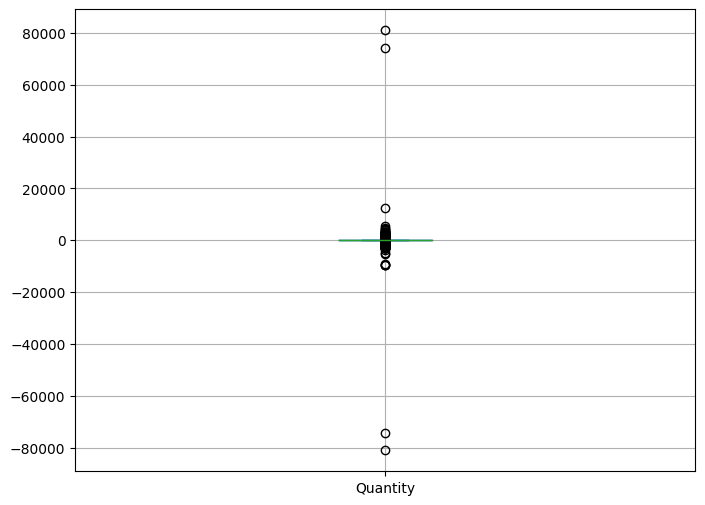

In [283]:
df['Quantity'].plot.box(
  showfliers=True,
  grid=True,
  figsize=(8,6)
)

In [284]:
df = df.loc[df['Quantity']>0]

In [285]:
df.shape

(531285, 8)

Dropping NaN records: We need to drop records with no CustomerID. Since we
are going to build a machine learning model to predict the 3 month customer
value, we need to group the data by the CustomerID column. Without it, we
cannot properly build models for this project. The code to drop records with no
CustomerID values looks like the following code snippet:

In [286]:
df.dropna(subset=['CustomerID'], inplace=True)

In [287]:
df.shape

(397924, 8)

- Excluding Incomplete Month

In [288]:
print('Data Range: %s ~ %s' % (df['InvoiceDate'].min() , df['InvoiceDate'].max()))

Data Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [289]:
df.loc[
  df['InvoiceDate'] >= '2011-12-01'
].shape

(17304, 8)

In [290]:
df = df.loc[
  df['InvoiceDate'] < '2011-12-01'
]

In [291]:
df.shape

(380620, 8)

- Total Sales

In [292]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [293]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


- Per Order Data

In [294]:
orders_df = df.groupby([
  'CustomerID', 'InvoiceNo'
]).agg({
  'Sales':sum,
  'InvoiceDate':max
})

orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

As you can see from this code, we are grouping the DataFrame df by two
columns, CustomerID and InvoiceNo. Then, we are summing up all of
the Sales values for each customer and order, and taking the last transaction
time for the given order as InvoiceDate. This way we now have a DataFrame,
orders_df, as we need to know about each order that each customer placed.

# 3. Data Analysis

In order to calculate the CLV, we need to know the frequency, recency, and total amount of
purchases by each customer. We are going to compute basic information about each
customer's average and lifetime purchase amount, as well as each customer's duration and
frequency of purchases.

In [295]:
orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [296]:
def groupby_mean(x):
  return x.mean()
  
def groupby_count(x):
  return x.count()
  
def purchase_duration(x):
  return (x.max() - x.min()).days

def avg_frequency(x):
  return (x.max() - x.min()).days / x.count()


groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [297]:
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
  'Sales': [min, max, sum, groupby_mean, groupby_count],
  'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

summary_df

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000     1   
12347.0       382.52   1294.32   4085.18    680.863333     6   
12348.0       227.44    892.80   1797.24    449.310000     4   
12349.0      1757.55   1757.55   1757.55   1757.550000     1   
12350.0       334.40    334.40    334.40    334.400000     1   
...              ...       ...       ...           ...   ...   
18280.0       180.60    180.60    180.60    180.600000     1   
18281.0        80.82     80.82     80.82     80.820000     1   
18282.0       100.21    100.21    100.21    100.210000     1   
18283.0         1.95    313.65   1886.88    125.792000    15   
18287.0        70.68   1001.32   1837.28    612.426667     3   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   
...                        ...                 ...               ...   
18280.0    2011-03-07 09:52:00 2011-03-07 09:52:00                 0   
18281.0    2011-06-12 10:53:00 2011-06-12 10:53:00                 0   
18282.0    2011-08-05 13:35:00 2011-08-05 13:35:00                 0   
18283.0    2011-01-06 14:14:00 2011-11-30 12:59:00               327   
18287.0    2011-05-22 10:39:00 2011-10-28 09:29:00               158   

                               
           purchase_frequency  
CustomerID                     
12346.0              0.000000  
12347.0             54.500000  
12348.0             70.500000  
12349.0              0.000000  
12350.0              0.000000  
...                       ...  
18280.0              0.000000  
18281.0              0.000000  
18282.0              0.000000  
18283.0             21.800000  
18287.0             52.666667  

[4298 rows x 9 columns]

In [298]:
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [299]:
summary_df.shape

(4298, 9)

In [300]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration']>0]
summary_df.shape

(2692, 9)

In [301]:
summary_df.head()

,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
CustomerID,,,,,,,,,
12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000
12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
12352.0,120.33,840.30,2506.04,313.255000,8,2011-02-16 12:33:00,2011-11-03 14:37:00,260,32.500000
12356.0,58.35,2271.62,2811.43,937.143333,3,2011-01-18 09:50:00,2011-11-17 08:40:00,302,100.666667
12359.0,547.50,2876.85,6372.58,1593.145000,4,2011-01-12 12:43:00,2011-10-13 12:47:00,274,68.500000


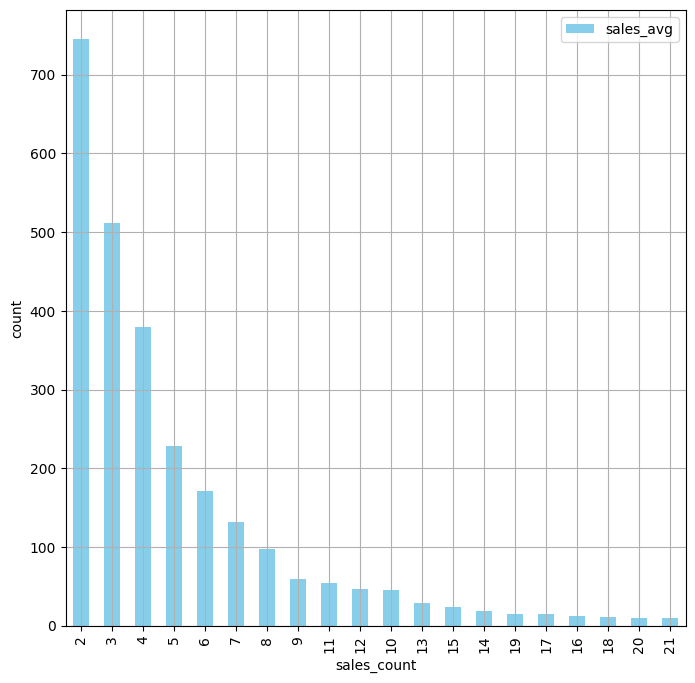

In [302]:
ax = pd.DataFrame(summary_df.groupby('sales_count').count()['sales_avg']).sort_values('sales_avg', ascending=False)[:20].plot(
  kind='bar',
  grid=True,
  figsize=(8,8),
  color='skyblue'
)

ax.set_ylabel('count')

plt.show()

As you can see from this plot, the majority of customers have made 10 or less purchases
historically.

In [303]:
summary_df['sales_count'].describe()

count    2692.000000
mean        5.971025
std         8.878128
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max       201.000000
Name: sales_count, dtype: float64

In [304]:
summary_df['sales_avg'].describe()

count     2692.000000
mean       391.458687
std        465.584404
min          3.450000
25%        197.661000
50%        306.043333
75%        444.524000
max      14844.766667
Name: sales_avg, dtype: float64

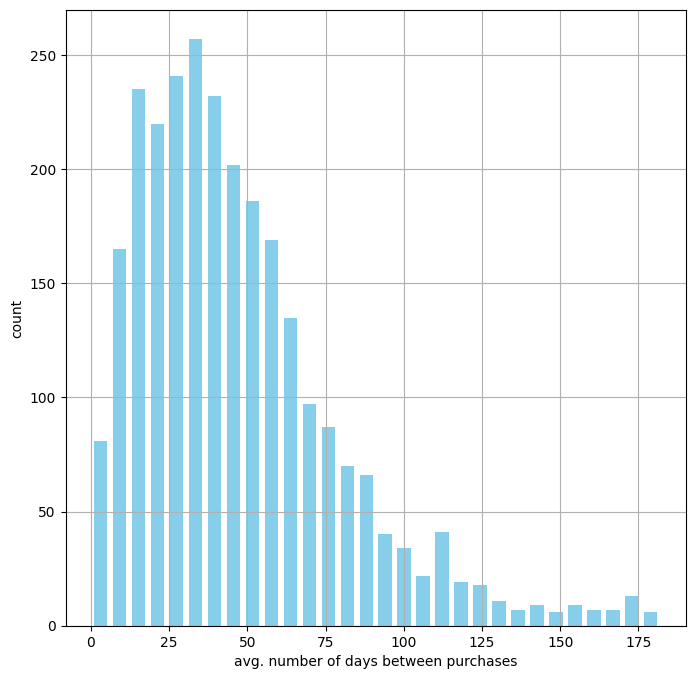

In [305]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
  bins=30,
  color='skyblue',
  figsize=(8,8),
  rwidth=0.7
)

ax.set_ylabel('count')
ax.set_xlabel('avg. number of days between purchases')

plt.show()

This plot tells us the overall view of how frequently repeat customers made purchases
historically. As you can see from this plot, the majority of repeat customers made purchases
every 20 to 50 days.

In [306]:
summary_df['invoicedate_purchase_frequency'].describe()

count    2692.000000
mean       46.999022
std        32.395004
min         0.029412
25%        23.500000
50%        40.500000
75%        62.333333
max       182.000000
Name: invoicedate_purchase_frequency, dtype: float64

In [307]:
summary_df['invoicedate_purchase_duration'].describe()

count    2692.000000
mean      199.720282
std       107.816559
min         1.000000
25%       107.000000
50%       209.000000
75%       296.000000
max       364.000000
Name: invoicedate_purchase_duration, dtype: float64

# 4. Predicting 3-Month CLV

4.1. Data Preparation

We are going to first slice the
data into chunks of 3 months and take the last 3 months' data as the target for predictions
and the rest as the features. We will first prepare our data for model building and then train
a linear regression model for the 3 month customer value predictions.

In [308]:
clv_freq = '3M'

In [309]:
orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]

In [310]:
data_df = orders_df.reset_index().groupby([
  'CustomerID',
  pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
  'Sales':[sum, groupby_mean, groupby_count]
})

In [311]:
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


Since we want to predict the 3 month customer value, we are breaking down the data into
chunks of 3 months for each customer. As you can see in the groupby function, we group
the previously built DataFrame orders_df by CustomerID and a custom Grouper, which
groups InvoiceDate by every 3 months. Then, for each group of 3 month time windows,
we sum up all of the sales to get the total purchase amount, take the average of purchase
amount and the total number of purchases for the given period for each customer. This way
we have aggregate data that has purchase information for each customer for every 3
months.

In [312]:
date_month_map = {
  str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
    sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
  )
}

date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [313]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])

In [314]:
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1,M_1
6,12348.0,2010-12-31,892.80,892.800,1,M_5
7,12348.0,2011-03-31,227.44,227.440,1,M_4
8,12348.0,2011-06-30,367.00,367.000,1,M_3
9,12348.0,2011-09-30,310.00,310.000,1,M_2


As you can see from this code, we are encoding date values into M_1, M_2, M_3, and so
forth, where the smaller number represents more recent dates. For example, the
date 2011-12-31 is now encoded as M_1 and the date 2011-09-30 is now encoded as M_2.

- Building Sample Set

In [315]:
features_df = pd.pivot_table(
  data_df.loc[data_df['M']!='M_1'],
  values=['sales_sum', 'sales_avg', 'sales_count'],
  columns='M',
  index='CustomerID'
)

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df.head(10)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,NaN,NaN,77183.600,NaN,NaN,NaN,1.0,NaN,NaN,NaN,77183.60,NaN
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,NaN,NaN,334.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,334.40,NaN
12352.0,316.25,NaN,312.362,NaN,2.0,NaN,5.0,NaN,632.50,NaN,1561.81,NaN
12353.0,NaN,89.000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,89.00,NaN,NaN
12354.0,NaN,1079.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1079.40,NaN,NaN
12355.0,NaN,459.400,NaN,NaN,NaN,1.0,NaN,NaN,NaN,459.40,NaN,NaN
12356.0,NaN,481.460,2271.620,NaN,NaN,1.0,1.0,NaN,NaN,481.46,2271.62,NaN


In [316]:
features_df.shape

(3616, 12)

In [317]:
features_df = features_df.fillna(0)

In [318]:
features_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00


In [319]:
response_df = data_df.loc[
  data_df['M']=='M_1',
  ['CustomerID', 'sales_sum']
]

response_df.columns = ['CustomerID', 'CLV_'+clv_freq]

response_df.head(10)

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
25,12359.0,2876.85
28,12360.0,1043.78
33,12362.0,2119.85
37,12364.0,299.06
41,12370.0,739.28


As you can see from this code, we are taking the last 3 month period, the M_1 group, as the
target variable. The target column will be sales_sum, as we want to predict the next 3
month customer value, which is the total purchase amount that a given customer is likely to
make in the next 3 months.

In [320]:
response_df.shape

(2407, 2)

In [321]:
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,NaN
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,NaN
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,NaN
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,NaN
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,NaN
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,NaN
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


In [322]:
sample_set_df = sample_set_df.fillna(0)

In [323]:
sample_set_df.head()

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.00,0.000,77183.600,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.91,509.385,475.390,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.00,367.000,227.440,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.00,0.000,334.400,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.25,0.000,312.362,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73


In [324]:
sample_set_df['CLV_'+clv_freq].describe()

count     3616.000000
mean       511.558520
std       2371.743293
min          0.000000
25%          0.000000
50%          0.000000
75%        458.662500
max      68012.350000
Name: CLV_3M, dtype: float64

# 4.2. Regression Models

In [325]:
from sklearn.model_selection import train_test_split

In [326]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df if x not in ['CustomerID', target_var]]

In [327]:
x_train, x_test, y_train, y_test = train_test_split(sample_set_df[all_features], sample_set_df[target_var], test_size=0.3)

- Linear Regression Model

In [328]:
from sklearn.linear_model import LinearRegression

In [329]:
reg_fit = LinearRegression()
reg_fit.fit(x_train, y_train)

LinearRegression()

In [330]:
reg_fit.intercept_

7.98815326245068

In [331]:
coef = pd.DataFrame(list(zip(all_features, reg_fit.coef_)))
coef.columns = ['features', 'coef']

coef

,features,coef
0,sales_avg_M_2,0.155302
1,sales_avg_M_3,-0.491693
2,sales_avg_M_4,0.212481
3,sales_avg_M_5,-0.323109
4,sales_count_M_2,110.966845
5,sales_count_M_3,6.638198
6,sales_count_M_4,13.312861
7,sales_count_M_5,-69.701661
8,sales_sum_M_2,0.321525
9,sales_sum_M_3,0.348526


# 4.3. Evaluation

In [332]:
from sklearn.metrics import r2_score, median_absolute_error

In [333]:
train_preds = reg_fit.predict(x_train)
test_preds = reg_fit.predict(x_test)

In [334]:
print('In-Sample R-Squared: %0.4f' % r2_score(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true=y_test, y_pred=test_preds))

In-Sample R-Squared: 0.6967
Out-of-Sample R-Squared: 0.6837


In [335]:
print('In-Sample MSE: %0.4f' % median_absolute_error(y_true=y_train, y_pred=train_preds))
print('Out-of-Sample MSE: %0.4f' % median_absolute_error(y_true=y_test, y_pred=test_preds))

In-Sample MSE: 202.0780
Out-of-Sample MSE: 205.6285


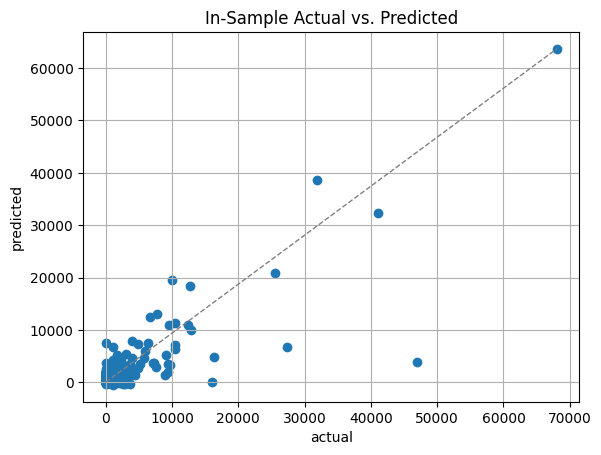

In [336]:
plt.scatter(y_train, train_preds)
plt.plot([0, max(y_train)], [0, max(train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()

plt.show()

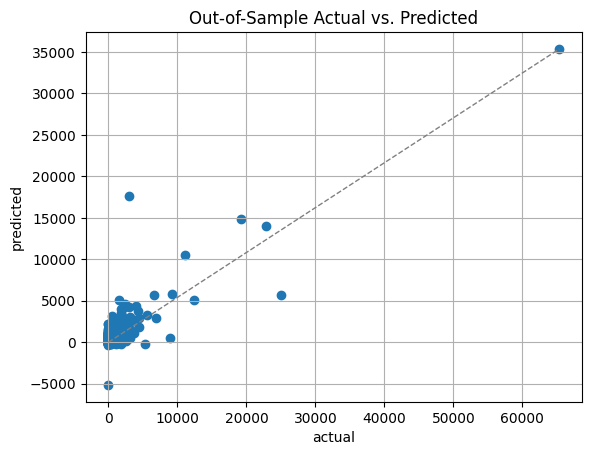

In [337]:
plt.scatter(y_test, test_preds)
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()